In [1]:
from astropy.io import fits
from astropy.wcs import WCS
import astropy.coordinates as coord
import astropy.units as u
import astropy.constants as constants
from astropy.time import Time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path

In [2]:
#data_path = "/Users/tere/NP-papers/Ou5_paper/FITS"
data_path = Path.cwd().parent / "data" / "tere-test"

In [3]:
fits_file = "N10036_bcrx_ha.fits"
hdulist = fits.open(f"{data_path}/{fits_file}")
hdulist.info() 

Filename: /Users/will/Dropbox/teresa-pn-ou5/data/tere-test/N10036_bcrx_ha.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (42, 121)   float32   


In [4]:
hdr = hdulist[0].header

In [5]:
location = coord.EarthLocation.of_site(hdr["OBSERVAT"])
obstime = Time(hdr["JD"], format="jd")
print("Time of observation =", obstime.datetime)
print("Location (lon, lat) =", location.lon.deg, location.lat.deg)

Time of observation = 2017-08-29 08:34:20.000025
Location (lon, lat) = -115.48694444444442 31.029166666666665


In [6]:
c = coord.SkyCoord(
    ra=hdr["RA"], 
    dec=hdr["DEC"], 
    obstime=obstime, 
    location=location,
    unit=(u.hourangle, u.deg)
    )
print(c.get_constellation())

Cygnus


In [7]:
c.radial_velocity_correction("heliocentric").to(u.km/u.s)

<Quantity 1.79234448 km / s>

In [8]:
def helio_corr_from_header(hdr):
    """Heliocentric correction in km/s"""
    location = coord.EarthLocation.of_site(hdr["OBSERVAT"])
    obstime = Time(hdr["JD"], format="jd")
    c = coord.SkyCoord(ra=hdr["RA"], dec=hdr["DEC"], 
                       obstime=obstime, location=location,
                       unit=(u.hourangle, u.deg))
    return c.radial_velocity_correction("heliocentric").to(u.km/u.s).value

In [9]:
#Test the function with the second file:
fits_file2 = "N10036_bcrx_ha.fits"
hdulist2 = fits.open(f"{data_path}/{fits_file2}")
hdr2 = hdulist2[0].header
hdulist2.info() 
data2 = hdulist2[0].data
helio_corr_from_header(hdr2)

Filename: /Users/will/Dropbox/teresa-pn-ou5/data/tere-test/N10036_bcrx_ha.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     143   (42, 121)   float32   


1.792344479725334

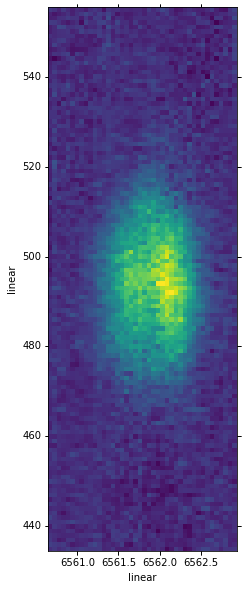

In [10]:
fig, ax = plt.subplots(
    figsize=(5, 10),
    subplot_kw=dict(projection=WCS(hdr2))
    )
ax.imshow(data2);

In [11]:
w0 = WCS(hdr2)
w0

WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 6542.41650390626  1.0  
CRPIX : -333.0  -433.0  
CD1_1 CD1_2  : 0.0546629056334498  0.0  
CD2_1 CD2_2  : 0.0  1.0  
NAXIS : 42  121

In [12]:
w = w0.deepcopy()
w.wcs.crpix[1] = 1
w.wcs.crval[1] = 0.0
w.wcs.cd[1, 1] = hdr2["SCALEPIX"] * hdr2["CCDYBIN"]
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : 6542.41650390626  0.0  
CRPIX : -333.0  1.0  
CD1_1 CD1_2  : 0.0546629056334498  0.0  
CD2_1 CD2_2  : 0.0  0.35369  
NAXIS : 42  121

In [13]:
wav0 = 6562.82
light_speed = constants.c.to(u.km/u.s).value
w.wcs.crval[0] = (w0.wcs.crval[0] - wav0) * light_speed / wav0
w.wcs.crval[0] += helio_corr_from_header(hdr2)
w.wcs.cd[0, 0] = w0.wcs.cd[0, 0] * light_speed / wav0
w.wcs.cname = "Velocity", "Offset [arcsec]"
w.wcs.cunit = "km/s", ""
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'LINEAR'  'LINEAR'  
CRVAL : -930.2481877511791  0.0  
CRPIX : -333.0  1.0  
CD1_1 CD1_2  : 2.4970251875373637  0.0  
CD2_1 CD2_2  : 0.0  0.35369  
NAXIS : 42  121

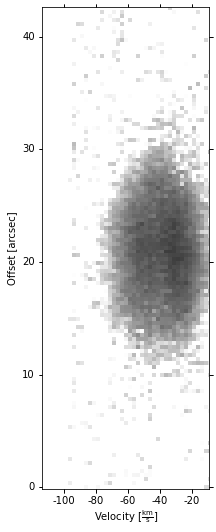

In [14]:
fig, ax = plt.subplots(
    figsize=(3, 10),
    subplot_kw=dict(projection=w)
    )
ax.imshow(data2,cmap='gist_yarg', norm=LogNorm(vmin=2, vmax=100));
plt.title('')
plt.xticks((0,100,0))
plt.xlim(-7,35)
plt.show
fig.savefig("N10036.pdf")

In [15]:
new_hdr = hdr2.copy()
new_hdr.update(w.to_header())

In [16]:
fits.PrimaryHDU(
    header=new_hdr, data=data2,
).writeto(
    fits_file2.replace(".fits", "_wcs.fits"),
    overwrite=True,
    )

In [22]:
c.galactic

<SkyCoord (Galactic): (l, b) in deg
    (87.06417334, -3.52013383)>

In [18]:
print(c)

<SkyCoord (ICRS): (ra, dec) in deg
    (318.76791667, 43.77777778)>


In [23]:
c1 = coord.SkyCoord.from_name("PN Ou 5")

In [26]:
c.separation(c1).arcmin

9.466685469645567